# Taking a stab at the data
So to begin with, I wrote a routine to load the dataset

I became apparent, that the ñ and é chars of dc\\Extraño.txt and dc\\Tefé\_Holland.txt filenames were a problem after extracting the files on my Windows box, so I manually renamed them.


In [1]:
import os
import numpy as np

# Reads a single file and returns its contents as a string
def read_text(filename):
    txt=''
    with open(filename,'rU') as f:
        txt = f.read()
    assert txt!='','no text read'
    return txt

# reads all *.txt files in folder and returns a list of filecontents
def get_files_in_folder(folder):
    files = []
    for f in os.listdir(folder):
        if f.endswith('.txt'):
            files.append(read_text(os.path.join(folder,f)))
    return files



In [2]:
# get the files
dcfiles = get_files_in_folder('dc')
marvelfiles = get_files_in_folder('marvel')

#concatenate the lists
texts = dcfiles+marvelfiles

#construct text labels for future use
labels = np.array([0]* len(dcfiles)+[1]*len(marvelfiles))

## First feature set
Having no pre-conceived ideas about the texts, I thought: "How about a simple Bag-of-Words" to summarize the texts, and then I figured, that TfIdf would filter the more common words, and thus leave the "most important" words

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer as VEC
from sklearn.preprocessing import normalize

# create a simple word-relevance vectorization of each file
vec = VEC(max_features=2000, stop_words='english')
vecfeatures = normalize(vec.fit_transform(texts).toarray())


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from __future__ import division

# build a logistic regression classifier with L2 regularizer
logreg = LogisticRegression(penalty='l2')

# dataset only holds 761 texts, so to make use of everything better use KFold crossvalidation
kfold = StratifiedKFold(labels,n_folds=5, random_state=1)

# let's see where it gets us
cvs = cross_val_score(logreg, vecfeatures, labels,cv=kfold)
print "Kfold CV:", cvs
print "Avg:", cvs.mean()


Kfold CV: [ 0.97385621  0.97385621  0.96732026  0.9602649   0.98013245]
Avg: 0.971086006146


## 97% ?!
Ok, 97.1% is a decent first attempt. Let's have a look at the split

(array([ 10.,  14.,  29.,  22.,  35.,  36.,  30.,  32.,  24.,  35.,  41.,
         22.,  23.,  17.,   6.,   7.,   9.,   4.,   3.,   2.,   3.,   0.,
          0.,   1.,   2.,   0.,   5.,   3.,   4.,   3.,   3.,   9.,   9.,
         11.,  15.,  15.,  22.,  26.,  15.,  20.,  26.,  29.,  25.,  14.,
         19.,  19.,  18.,  18.,  19.,   7.]),
 array([ 0.0357492 ,  0.05429197,  0.07283475,  0.09137753,  0.10992031,
         0.12846308,  0.14700586,  0.16554864,  0.18409142,  0.2026342 ,
         0.22117697,  0.23971975,  0.25826253,  0.27680531,  0.29534808,
         0.31389086,  0.33243364,  0.35097642,  0.3695192 ,  0.38806197,
         0.40660475,  0.42514753,  0.44369031,  0.46223308,  0.48077586,
         0.49931864,  0.51786142,  0.53640419,  0.55494697,  0.57348975,
         0.59203253,  0.61057531,  0.62911808,  0.64766086,  0.66620364,
         0.68474642,  0.70328919,  0.72183197,  0.74037475,  0.75891753,
         0.77746031,  0.79600308,  0.81454586,  0.83308864,  0.85163142,
 

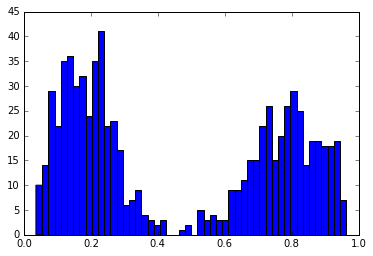

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt

# fit a logistic regression model to everything
model = logreg.fit(vecfeatures, labels)

# and let's see the training probabilities
probs = model.predict_proba(vecfeatures)

plt.hist(probs[:,0],bins=50)

#### Ok, looks like two distinct sets
There are a bit of confusion around the .50 mark, which would account for the 2.9% misclassification.

In [6]:
ambiguous = np.where(np.logical_and(probs[:,0] > 0.45,probs[:,0] < 0.55))
print "# of those in the 45-55% renge: ", len(ambiguous[0])

print ambiguous[0]

# of those in the 45-55% renge:  11
[  2  98 145 171 200 238 242 315 353 417 651]


Ok, so number 2 and number 353 are the same, a cross-over maybe understandable that it get's confused. Number 145 is Iron Butterfly, and I guess "Iron" would influence heavily in the Marvel direction because of Iron Man and the many interactions he has with Marvel heros.
Number 651 is Red Sonja, and since there are two DC-heros named Red Tornado and Red Torpedo, I'm guessing 'Red' would lean towards DC

I haven't looked closer at the rest, but I guess it's appearent that the vectorizer could be improved by looking specifically for the heros' full names.

## A few too many errors?
Normally, I wouldn't mind 97.1% accuracy, but maybe we can work a bit with the data.

First: What are the features used? 

### The TD-IDF features
Let's have a look at the most important features in the TF-IDF featureset

In [12]:
np.array(vec.get_feature_names())[np.where(logreg.coef_[0,:] > 0.5)[0]]

array([u'1987', u'2099', u'academy', u'alpha', u'appearing', u'ar',
       u'armor', u'avengers', u'battled', u'bloodstone', u'books',
       u'cable', u'captain', u'cyclops', u'daredevil', u'darkhawk',
       u'deadpool', u'diamond', u'excalibur', u'exiles', u'fantastic',
       u'fury', u'gabriel', u'goblin', u'guard', u'hulk', u'imperial',
       u'initiative', u'institute', u'invaders', u'jack', u'kree',
       u'magneto', u'man', u'men', u'mutant', u'mutants', u'osborn',
       u'pack', u'phoenix', u'process', u'quasar', u'rider', u'shi',
       u'skrull', u'skull', u'spider', u'stark', u'superhuman', u'supreme',
       u'team', u'thanos', u'thor', u'thunderbolts', u'ultimate', u'venom',
       u'warlock', u'warriors', u'wolverine', u'xavier', u'york'], 
      dtype='<U15')

In [13]:
np.array(vec.get_feature_names())[np.where(logreg.coef_[0,:] < -0.5)[0]]

array([u'52', u'action', u'aquaman', u'arrow', u'artemis', u'atom', u'bat',
       u'batman', u'birds', u'boy', u'brainiac', u'characters', u'city',
       u'comics', u'constantine', u'corps', u'crisis', u'deathstroke',
       u'flash', u'golden', u'gotham', u'green', u'guardians', u'hal',
       u'heroes', u'icon', u'infinite', u'jla', u'jordan', u'jsa',
       u'justice', u'lane', u'lantern', u'lanterns', u'league', u'legion',
       u'lightning', u'luthor', u'magic', u'outsiders', u'patrol',
       u'quality', u'rex', u'robin', u'rorschach', u'rose', u'shadow',
       u'society', u'spectre', u'star', u'starman', u'super', u'superboy',
       u'supergirl', u'superman', u'swamp', u'teen', u'titans', u'tornado',
       u'woman', u'wonder', u'young'], 
      dtype='<U15')

So, no suprises really, The most important features with a positive coefficient (pointing towards Marvel) rhyme with Deadpool, Hulk and the X-Men, whereas the negative coefficients are Arrow, The Flash, Justice League and Superman (DC)

Now, a new superhero, who has had no interaction with the other, would be hard to classify using the learned model. I'm not going down this rabbit hole though (Remove super hero names from tf-idf vocabulary, presumably using some kind of Named Entity Recogniser).

## Vocabulary size
So, I picked 2K out of my ... limited imagination.  Maybe there's something to gain from a smaller or larger vocabulary?

In [15]:
def get_features(vocabsize):
    _vec = VEC(max_features=vocabsize, stop_words='english')
    _vecfeatures = normalize(_vec.fit_transform(texts).toarray())
    return _vecfeatures

def calc_crossval_score_logreg(vocabsize, vals, kfold):
    _features = get_features(int(vocabsize))
    _logreg = LogisticRegression()
    return cross_val_score(_logreg,_features,vals,cv=kfold).mean()
   
    
    

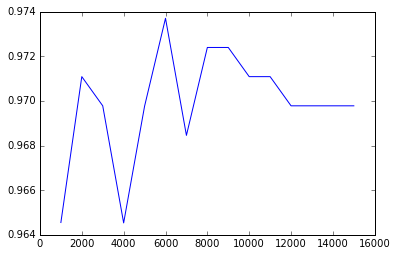

In [16]:
vocabsizes = np.linspace(1000, 15000,15)
cvs_logreg = [calc_crossval_score_logreg(s, labels, kfold) for s in vocabsizes]

plt.plot(vocabsizes, cvs_logreg)

It would appear, that 6000 words is somewhat better than the rest, and everything beyond 12K is a waste of time - presumably because all the good features are among the 12k most important words (tf-idf wise). The dips at 4k and 7k though...?!

For good measure, let's see the interval 0-1000 and 5500-6500.



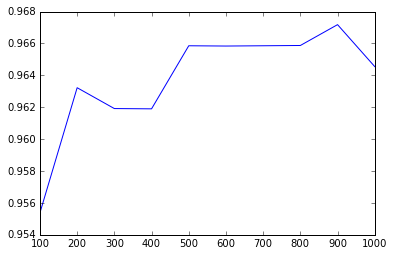

In [17]:
# logreg with 0-1000 feature words
vocabsizes2 = np.linspace(100, 1000,10)
cvs_logreg2 = [calc_crossval_score_logreg(s, labels, kfold) for s in vocabsizes2]
plt.plot(vocabsizes2,cvs_logreg2)


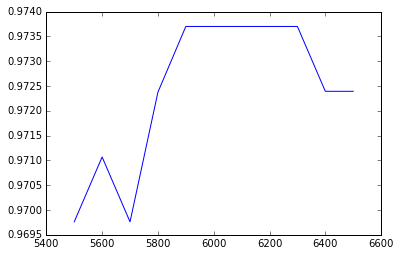

In [18]:
# logreg with 0-1000 feature words
vocabsizes3 = np.linspace(5500, 6500,11)
cvs_logreg3 = [calc_crossval_score_logreg(s, labels, kfold) for s in vocabsizes3]
plt.plot(vocabsizes3,cvs_logreg3)

## Conclusion on Logistic Regression
It would appear, that a feature-set of the first 6000 TF/IDF vectors performs quite well.


In [19]:
vecfeatures = get_features(6000)
print cross_val_score(logreg, vecfeatures, labels, cv=kfold).mean()

0.973700385231


# Clustering, anyone?
Ok, with two distinct sets such as this, maybe KNN is a viable alternative

In [20]:
from sklearn.neighbors import KNeighborsClassifier as KNN
knn = KNN()

# I'll reuse the 6K features from before for now
vecfeatures = get_features(6000)

rKnnCrossVal = cross_val_score(knn,vecfeatures,labels,cv=kfold)
print rKnnCrossVal.mean()

0.944855646453


Ok, looks promising

In [22]:
def calc_crossval_score_knn(neighbours, features, vals, kfold):
    _knn = KNN(int(neighbours))
    return cross_val_score(_knn,features,vals,cv=kfold).mean()


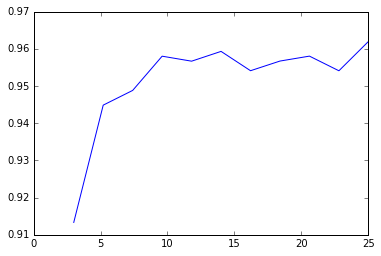

In [23]:
# let's see for uneven K = 3:25 
ks = np.linspace(3, 25, 11)
cvs = [calc_crossval_score_knn(k, vecfeatures, labels, kfold) for k in ks]

plt.plot(ks,cvs)

### Partial conclusion 
It appears that 9+ neighbours are enough, and 13 looks to be very good indeed (ok, 25 is better, but 25...)
let's see if we can achieve similar results but with a smaller feature set

In [24]:
def calc_crossval_score_knn2(vocabsize, vals, kfold):
    _knn = KNN(13)
    _features = get_features(int(vocabsize))
    return cross_val_score(_knn,_features,vals,cv=kfold).mean()



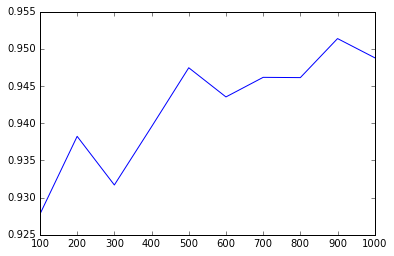

In [25]:
voc_sizes2 = np.linspace(100,1000,10)
cvs2 = [calc_crossval_score_knn2(v, labels, kfold) for v in voc_sizes2]
plt.plot(voc_sizes2, cvs2)

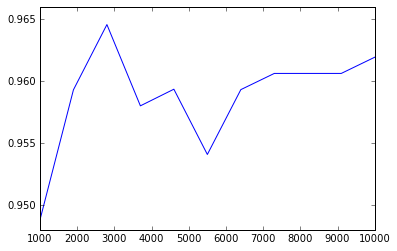

In [26]:
voc_sizes3 = np.linspace(1000,10000,11)
cvs3 = [calc_crossval_score_knn2(v, labels, kfold) for v in voc_sizes3]
plt.plot(voc_sizes3, cvs3)

### D'oh!
Vocabulary of 3K was a better fit..

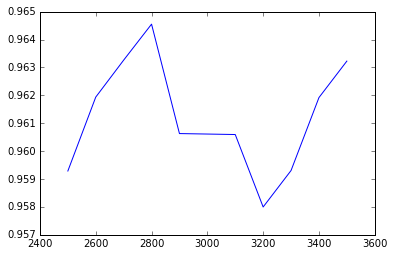

In [27]:
voc_sizes4 = np.linspace(2500,3500,11)
cvs4 = [calc_crossval_score_knn2(v, labels, kfold) for v in voc_sizes4]
plt.plot(voc_sizes4, cvs4)

### Let's revisit the K-search

In [28]:
vecfeatures = get_features(2800)
print cross_val_score(knn, vecfeatures, labels, cv=kfold)

[ 0.92156863  0.94117647  0.94117647  0.95364238  0.94701987]


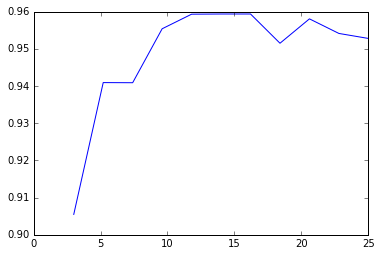

In [29]:
cvs5 = [calc_crossval_score_knn(k, vecfeatures, labels, kfold) for k in ks]
plt.plot(ks, cvs5)

## Conclusion on KNN
So, It appears that KNN maxes out at 96%, which is respectable. And with a featureset about half the size of Logistic Regression.

I didn't do a full grid-search of K's vs. Vocabsize, which could've found a better set of parameters.

# Conclusion on this little exploration
Logistic Regression and K-Nearest Neighbours both perform well on the dataset, at 97% and 96% respectively. I'm going to prefer the Logistic Regression, because the model-representation is "only" 1x6000 weights, whereas the KNN model would be a 761x2800 vectors. Also the prediction is simpler :1 dot product, KNN is 761 comparisons (in the naïve approach)

# Create initial database
I wrote a DAL class to abstract away the choice of database provider.. Figured i may as well populate the database right away

In [30]:
from SHpersistence import SuperHeroStore
store = SuperHeroStore('data.json')
store.nuke_everything()

In [31]:
# read the files from folder and populate database
# reads all *.txt files in folder and returns a list of filecontents
def put_data_in_database(folder):
    for f in os.listdir(folder):
        if f.endswith('.txt'):
            print f[:-4]
            store.create_hero(f[:-4], read_text(os.path.join(folder,f)), folder)

In [32]:
put_data_in_database(u'dc')
put_data_in_database(u'marvel')

711
abin_sur
access
ace_the_bat_hound
adam_strange
alan_scott
albert_rothstein
alexander_luthor_jr
alternative_versions_of_robin
amazing_man
anarky
ant
antaeus
apache_chief
aquagirl
aqualad
aquaman
aquawoman
argent
arion
arm_fall_off_boy
artemis_of_bana_mighdall
atlas
atmos
azrael
baby_wildebeest
ballistic
barbara_gordon
baron_bedlam
batgirl
batman
battalion
bat_cow
bat_mite
belyllioth
big_barda
bizarra
bizarro
black_canary
black_lightning
black_vulcan
blok
bloodwynd
blue_devil
boodikka
bork
bouncing_boy
bozo_the_iron_man
brainiac_5
brainiac_8
brainwave
bulleteer
bunker
bushido
bushmaster
captain_atom
captain_boomerang
captain_carrot
captain_comet
captain_triumph
celsius
centrix
champions_of_angor
chas_chandler
chlorophyll_kid
chris_kl_99
chronos
coagula
codename_assassin
comet
commander_steel
cosmic_boy
creeper
creote
crimson_fox
cyborg
dan_the_dyna_mite
dawnstar
detective_chimp
devlin_oryan
dharma
dingbats_of_danger_street
doctor_fate
doctor_occult
doctor_thirteen
doll_girl
doll_man
